## Table of Contents

- [Data Wrangling + Cleaning](#Data-Wrangling-+-Cleaning)
- [Exploratory Data Analysis](#EDA)
- [Relationship of Total New ARR and Other Categories](#Total-Closed-Compared-to-Other-Variables)
- [Analysis of the Sales Cycle](#-Understanding-Sales-Stages-for-the-year)

In [1]:
#import all relevant Python libraries for the analysis
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns

# Data Wrangling + Cleaning

1. Load the data into pandas dataframes
2. Assess each dataframe
3. Create relevant columnns for the analysis and remove any that may be irrelevant
4. Merge all dataframes for into one




In [2]:
# Loading in all five datasets into dataframes

#Account information dataframe
accounts_df = pd.read_csv('accounts.csv')

#Information on Products dataframe
products_df = pd.read_csv('products.csv')

#Information on each Sales Team dataframe
sales_teams_df = pd.read_csv('sales_teams.csv')

#Pipeline data for each oppurtunity in the CRM dataframe
sales_pipeline_df = pd.read_csv('sales_pipeline.csv')

#Metadata dataframe breaking down the column for all the dataframes above
metadata_df = pd.read_csv('metadata.csv')

In [3]:
# Inspecting the Accounts dataframe
accounts_df.head()

,account,sector,year_established,revenue,employees,office_location,subsidiary_of
0,Acme Corporation,technolgy,1996,1100.04,2822,United States,NaN
1,Betasoloin,medical,1999,251.41,495,United States,NaN
2,Betatech,medical,1986,647.18,1185,Kenya,NaN
3,Bioholding,medical,2012,587.34,1356,Philipines,NaN
4,Bioplex,medical,1991,326.82,1016,United States,NaN


In [4]:
# For the employees column, we want to categorize the employee size into the corresponding size category 

bins = [0, 750, 1500, 100000]
labels = ['SMB', 'Mid-Market', 'Enterprise']
accounts_df['size_category'] = pd.cut(accounts_df['employees'], bins = bins, labels = labels)

#Dropping column irrelevant to the rest of the project 
accounts_df.drop(columns=['year_established','subsidiary_of'], inplace=True)
accounts_df.head()

,account,sector,revenue,employees,office_location,size_category
0,Acme Corporation,technolgy,1100.04,2822,United States,Enterprise
1,Betasoloin,medical,251.41,495,United States,SMB
2,Betatech,medical,647.18,1185,Kenya,Mid-Market
3,Bioholding,medical,587.34,1356,Philipines,Mid-Market
4,Bioplex,medical,326.82,1016,United States,Mid-Market


In [5]:
# Inspecting the Products dataframe, no changes needed at this time
products_df.head()

,product,series,sales_price
0,GTX Basic,GTX,550
1,GTX Pro,GTX,4821
2,MG Special,MG,55
3,MG Advanced,MG,3393
4,GTX Plus Pro,GTX,5482


In [6]:
# Inspecting the Sales teams dataframe, no changes needed at this time
sales_teams_df.head()

,sales_agent,manager,regional_office
0,Anna Snelling,Dustin Brinkmann,Central
1,Cecily Lampkin,Dustin Brinkmann,Central
2,Versie Hillebrand,Dustin Brinkmann,Central
3,Lajuana Vencill,Dustin Brinkmann,Central
4,Moses Frase,Dustin Brinkmann,Central


In [7]:
# Inspecting the Sales Pipeline dataframe
sales_pipeline_df.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0


In [8]:
#We want to understand how long each deal took to reach Closed Won status, so changing to datetime type to calculate duration
sales_pipeline_df['engage_date'] = pd.to_datetime(sales_pipeline_df['engage_date'])
sales_pipeline_df['close_date'] = pd.to_datetime(sales_pipeline_df['close_date'])#

#Calculate the duration of the sales cycle from prospecting to closed won, not applicable to deals not in Closed Won stage 
sales_pipeline_df['cycle_duration'] = sales_pipeline_df['close_date'] - sales_pipeline_df['engage_date'] 

# Summary stats for cycle duration
sales_pipeline_df['cycle_duration'].describe()

count                          6711
mean     47 days 23:38:58.310236924
std      41 days 01:23:02.227801968
min                 1 days 00:00:00
25%                 8 days 00:00:00
50%                45 days 00:00:00
75%                85 days 00:00:00
max               138 days 00:00:00
Name: cycle_duration, dtype: object

In [9]:
sales_pipeline_df['cycle_duration'] = sales_pipeline_df['cycle_duration'].dt.total_seconds() / (24*60*60)

In [10]:
sales_pipeline_df['cycle_duration'].fillna(0)
sales_pipeline_df['cycle_duration'].describe()

count    6711.000000
mean       47.985397
std        41.057665
min         1.000000
25%         8.000000
50%        45.000000
75%        85.000000
max       138.000000
Name: cycle_duration, dtype: float64

In [11]:
sales_pipeline_df['cycle_duration'].dtypes

dtype('float64')

In [12]:
# Next we want to understand how each quarter performed overall, so we going to categorzie the close date into the quarter it took place
def quarter_close_pip(date):
    day = date.month
    year = str(date.year)
    if day in [1,2,3]:
        return 'Q1 ' +year
    elif day in [4,5,6]:
        return 'Q2 ' +year
    elif day in [7,8,9]:
        return 'Q3 ' +year
    elif day in [10,11,12]:
        return 'Q4 ' +year

sales_pipeline_df['quarter_close'] = sales_pipeline_df['close_date'].apply(quarter_close_pip)
sales_pipeline_df.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,cycle_duration,quarter_close
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,132.0,Q1 2017
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,137.0,Q1 2017
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,133.0,Q1 2017
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,135.0,Q1 2017
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,128.0,Q1 2017


In [13]:
sales_pipeline_df['deal_stage'].unique()

array(['Won', 'Engaging', 'Lost', 'Prospecting'], dtype=object)

In [14]:
#Turn the deal stage into a categorical variable to perform summary stats later
sales_pipeline = ['Prospecting', 'Engaging', 'Lost', 'Won']
sales_pipeline_df['deal_stage'] = pd.Categorical(sales_pipeline_df['deal_stage'], sales_pipeline, ordered=True)

In [15]:
#Merging all four relevant dataframes into one
merge_1 = pd.merge(sales_pipeline_df, accounts_df, on="account")
merge_2 = pd.merge(merge_1, sales_teams_df, on="sales_agent")
df_sales_data = pd.merge(merge_2, products_df, on="product")
df_sales_data.rename(columns={'revenue':'account_revenue', 'employees':'account_employees', 'sector':'account_sector'}, inplace=True)
df_sales_data.head(10)

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,cycle_duration,quarter_close,account_sector,account_revenue,account_employees,office_location,size_category,manager,regional_office,series,sales_price
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,132.0,Q1 2017,retail,718.62,2448,United States,Enterprise,Dustin Brinkmann,Central,GTX,1096
1,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,133.0,Q1 2017,retail,718.62,2448,United States,Enterprise,Melvin Marxen,Central,MG,55
2,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,135.0,Q1 2017,software,2714.90,2641,United States,Enterprise,Dustin Brinkmann,Central,GTX,550
3,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,128.0,Q1 2017,services,792.46,1299,United States,Mid-Market,Summer Sewald,West,GTX,550
4,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,123.0,Q1 2017,medical,3922.42,6837,United States,Enterprise,Dustin Brinkmann,Central,MG,55
5,9ME3374G,Vicki Laflamme,MG Special,J-Texon,Won,2016-10-30,2017-03-02,57.0,123.0,Q1 2017,retail,1388.67,3583,United States,Enterprise,Celia Rouche,West,MG,55
6,7GN8Q4LL,Markita Hansen,GTX Basic,Cheers,Won,2016-11-01,2017-03-07,601.0,126.0,Q1 2017,entertainment,4269.90,6472,United States,Enterprise,Celia Rouche,West,GTX,550
7,OLK9LKZB,Niesha Huffines,GTX Plus Basic,Zumgoity,Won,2016-11-01,2017-03-03,1026.0,122.0,Q1 2017,medical,441.08,1210,United States,Mid-Market,Melvin Marxen,Central,GTX,1096
8,NL3JZH1Z,Anna Snelling,MG Special,Bioholding,Won,2016-11-04,2017-03-10,53.0,126.0,Q1 2017,medical,587.34,1356,Philipines,Mid-Market,Dustin Brinkmann,Central,MG,55
9,S8DX3XOU,James Ascencio,GTX Plus Pro,Sunnamplex,Won,2016-11-04,2017-03-10,5169.0,126.0,Q1 2017,marketing,894.37,1593,Poland,Enterprise,Summer Sewald,West,GTX,5482


In [16]:
df_sales_data.dtypes

opportunity_id               object
sales_agent                  object
product                      object
account                      object
deal_stage                 category
engage_date          datetime64[ns]
close_date           datetime64[ns]
close_value                 float64
cycle_duration              float64
quarter_close                object
account_sector               object
account_revenue             float64
account_employees             int64
office_location              object
size_category              category
manager                      object
regional_office              object
series                       object
sales_price                   int64
dtype: object

In [17]:
#Checking for duplicate rows, none found
df_sales_data.duplicated().value_counts()

False    6117
Name: count, dtype: int64

In [18]:
#Checking for null values
df_sales_data.isnull().sum()

opportunity_id         0
sales_agent            0
product                0
account                0
deal_stage             0
engage_date          129
close_date           553
close_value          553
cycle_duration       553
quarter_close        553
account_sector         0
account_revenue        0
account_employees      0
office_location        0
size_category          0
manager                0
regional_office        0
series                 0
sales_price            0
dtype: int64

In [19]:
df_sales_data['close_value'] = df_sales_data['close_value'].fillna(0)

In [20]:
df_sales_data.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,cycle_duration,quarter_close,account_sector,account_revenue,account_employees,office_location,size_category,manager,regional_office,series,sales_price
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,132.0,Q1 2017,retail,718.62,2448,United States,Enterprise,Dustin Brinkmann,Central,GTX,1096
1,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,133.0,Q1 2017,retail,718.62,2448,United States,Enterprise,Melvin Marxen,Central,MG,55
2,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,135.0,Q1 2017,software,2714.90,2641,United States,Enterprise,Dustin Brinkmann,Central,GTX,550
3,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,128.0,Q1 2017,services,792.46,1299,United States,Mid-Market,Summer Sewald,West,GTX,550
4,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,123.0,Q1 2017,medical,3922.42,6837,United States,Enterprise,Dustin Brinkmann,Central,MG,55


In [21]:
df_sales_data[df_sales_data['engage_date'].isnull()]

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,cycle_duration,quarter_close,account_sector,account_revenue,account_employees,office_location,size_category,manager,regional_office,series,sales_price
5988,6CWZFOHJ,Anna Snelling,GTX Basic,Green-Plus,Prospecting,NaT,NaT,0.0,NaN,None,services,692.19,1922,United States,Enterprise,Dustin Brinkmann,Central,GTX,550
5989,Q9UWOC28,Anna Snelling,GTX Plus Basic,Plusstrip,Prospecting,NaT,NaT,0.0,NaN,None,entertainment,349.81,315,United States,SMB,Dustin Brinkmann,Central,GTX,1096
5990,YL29KX3L,Anna Snelling,GTX Plus Basic,Zumgoity,Prospecting,NaT,NaT,0.0,NaN,None,medical,441.08,1210,United States,Mid-Market,Dustin Brinkmann,Central,GTX,1096
5991,9PDR4X2R,Anna Snelling,GTX Plus Pro,Hatfan,Prospecting,NaT,NaT,0.0,NaN,None,services,792.46,1299,United States,Mid-Market,Dustin Brinkmann,Central,GTX,5482
5992,9P9ISECL,Anna Snelling,GTX Plus Pro,Sumace,Prospecting,NaT,NaT,0.0,NaN,None,retail,167.89,493,Romania,SMB,Dustin Brinkmann,Central,GTX,5482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6112,VW8CEV4C,Versie Hillebrand,MG Special,Konmatfix,Prospecting,NaT,NaT,0.0,NaN,None,marketing,375.43,1190,United States,Mid-Market,Dustin Brinkmann,Central,MG,55
6113,KLUS7RVS,Versie Hillebrand,MG Special,Opentech,Prospecting,NaT,NaT,0.0,NaN,None,finance,355.23,853,United States,Mid-Market,Dustin Brinkmann,Central,MG,55
6114,ROM4I2T0,Versie Hillebrand,MG Special,Rundofase,Prospecting,NaT,NaT,0.0,NaN,None,technolgy,1008.06,1238,United States,Mid-Market,Dustin Brinkmann,Central,MG,55
6115,FCNN6UY0,Versie Hillebrand,MG Advanced,Ganjaflex,Prospecting,NaT,NaT,0.0,NaN,None,retail,5158.71,17479,Japan,Enterprise,Dustin Brinkmann,Central,MG,3393


In [22]:
# Seems data missing at the close value, quarter close, and cycle duration may be data missing structuctually since other deal stages not at Closed Won will not have this data filled
df_sales_data[df_sales_data['deal_stage'] == 'Won'].isnull().sum()

opportunity_id       0
sales_agent          0
product              0
account              0
deal_stage           0
engage_date          0
close_date           0
close_value          0
cycle_duration       0
quarter_close        0
account_sector       0
account_revenue      0
account_employees    0
office_location      0
size_category        0
manager              0
regional_office      0
series               0
sales_price          0
dtype: int64

In [23]:
df_sales_data.describe(include='all')

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,cycle_duration,quarter_close,account_sector,account_revenue,account_employees,office_location,size_category,manager,regional_office,series,sales_price
count,6117,6117,6117,6117,6117,5988,5564,6117.000000,5564.000000,5564,6117,6117.000000,6117.000000,6117,6117,6117,6117,6117,6117.000000
unique,6117,30,6,85,4,NaN,NaN,NaN,NaN,4,10,NaN,NaN,15,3,6,3,3,NaN
top,1C1I7A6R,Anna Snelling,GTX Basic,Hottechi,Won,NaN,NaN,NaN,NaN,Q3 2017,retail,NaN,NaN,United States,Enterprise,Dustin Brinkmann,Central,GTX,NaN
freq,1,379,1563,175,3509,NaN,NaN,NaN,NaN,1679,1162,NaN,NaN,5077,4334,1311,2459,3545,NaN
mean,NaN,NaN,NaN,NaN,NaN,2017-06-13 17:26:48.817635072,2017-08-01 06:33:54.219985664,1061.787804,48.449317,NaN,NaN,2452.836668,5639.306523,NaN,NaN,NaN,NaN,NaN,1886.640510
min,NaN,NaN,NaN,NaN,NaN,2016-10-20 00:00:00,2017-03-01 00:00:00,0.000000,1.000000,NaN,NaN,4.540000,9.000000,NaN,NaN,NaN,NaN,NaN,55.000000
25%,NaN,NaN,NaN,NaN,NaN,2017-04-02 00:00:00,2017-05-18 00:00:00,0.000000,8.000000,NaN,NaN,646.100000,1238.000000,NaN,NaN,NaN,NaN,NaN,550.000000
50%,NaN,NaN,NaN,NaN,NaN,2017-06-20 00:00:00,2017-08-02 00:00:00,56.000000,47.000000,NaN,NaN,1618.890000,3194.000000,NaN,NaN,NaN,NaN,NaN,1096.000000
75%,NaN,NaN,NaN,NaN,NaN,2017-08-30 00:00:00,2017-10-19 00:00:00,1062.000000,85.000000,NaN,NaN,2952.730000,7523.000000,NaN,NaN,NaN,NaN,NaN,3393.000000
max,NaN,NaN,NaN,NaN,NaN,2017-12-27 00:00:00,2017-12-31 00:00:00,30288.000000,138.000000,NaN,NaN,11698.030000,34288.000000,NaN,NaN,NaN,NaN,NaN,26768.000000


# EDA
The goal is to understand the summary statistics and ranges of the following variables relevant to the questions we would like to answer aboout this year's sales performance. We will focus on:
- number of sales agents under each manager
- account sector
- size category
- deal stages
- close value
- account revenue
- employee
- sales cycle duration to closed won


# Number of Sales agents for each manager

In [24]:
# Number of managers 
df_sales_data['manager'].nunique()

6

In [25]:
#Here we can see what manager has the most oppurtunies across the company

df_sales_data['manager'].value_counts(normalize=True)

manager
Dustin Brinkmann    0.214321
Melvin Marxen       0.187674
Summer Sewald       0.186039
Celia Rouche        0.154814
Rocco Neubert       0.147785
Cara Losch          0.109367
Name: proportion, dtype: float64

In [26]:
df_manager_group = df_sales_data.groupby('manager')['sales_agent'].nunique().reset_index()
df_manager_group

,manager,sales_agent
0,Cara Losch,5
1,Celia Rouche,5
2,Dustin Brinkmann,5
3,Melvin Marxen,5
4,Rocco Neubert,5
5,Summer Sewald,5


All managers have 5 total reps in their team.

# Account Sector

In [27]:
#Frequencies of sectors in our sales pipeline
df_sales_data['account_sector'].value_counts(normalize=True).reset_index()

,account_sector,proportion
0,retail,0.189962
1,technolgy,0.157757
2,medical,0.144679
3,software,0.099886
4,marketing,0.092692
5,finance,0.091221
6,telecommunications,0.068007
7,entertainment,0.062285
8,services,0.052150
9,employment,0.041360


Retail companies are 18% of our pipeline, with employment companies representing the lowest in the pipeline at nearly 4%.

# Deal Size Category

In [28]:
#Frequencies of deal categories in our sales pipeline
df_sales_data['size_category'].value_counts(normalize=True).reset_index()

,size_category,proportion
0,Enterprise,0.708517
1,Mid-Market,0.157103
2,SMB,0.134380


Nearly 70% percent of the year's salespiple was generated from Enterprise level companies

# Deal Stage

In [29]:
#Frequencies of deal stages in our sales pipeline
df_sales_data['deal_stage'].value_counts(normalize=True).reset_index()

,deal_stage,proportion
0,Won,0.573647
1,Lost,0.335949
2,Engaging,0.069315
3,Prospecting,0.021089


Surprisingly, over half of deals in the pipeline over the year closed

In [30]:
#Isolating the quantitaive columns from out dataset
quatitative_sales_features = ['close_value', 'account_revenue', 'account_employees', 'cycle_duration']
df_sales_data[quatitative_sales_features].describe()

,close_value,account_revenue,account_employees,cycle_duration
count,6117.000000,6117.000000,6117.000000,5564.000000
mean,1061.787804,2452.836668,5639.306523,48.449317
std,2104.520914,2579.883527,6725.775735,41.150545
min,0.000000,4.540000,9.000000,1.000000
25%,0.000000,646.100000,1238.000000,8.000000
50%,56.000000,1618.890000,3194.000000,47.000000
75%,1062.000000,2952.730000,7523.000000,85.000000
max,30288.000000,11698.030000,34288.000000,138.000000


In [31]:
def plotting_boxplot_histogram(df, column):
    title = column.replace('_',' ').title()

    sns.set(style="whitegrid")

    #Histogram 
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    sns.histplot(df[column], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title('Distribution of {}'.format(title))
    plt.xlabel(title)
    plt.ylabel('Frequency')
               
    plt.subplot(1,2,2)
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title('Boxplot of {}'.format(title))
    plt.xlabel(title)
               
    plt.tight_layout()
    plt.show()

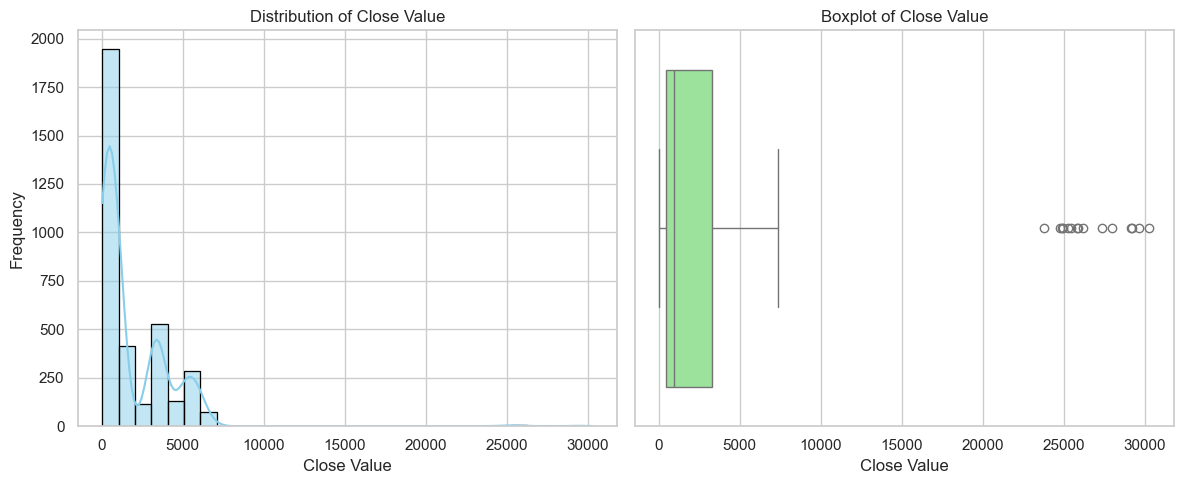

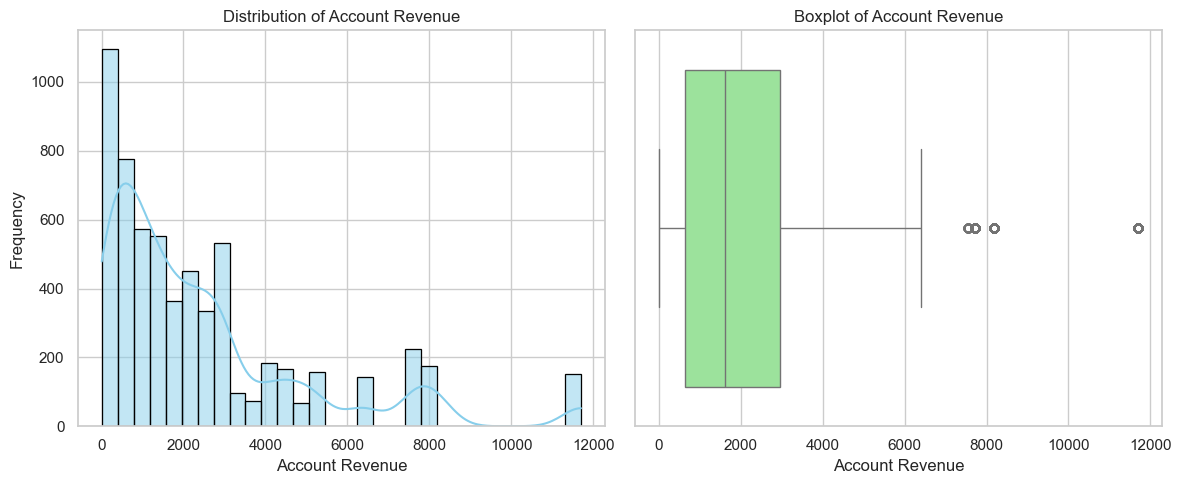

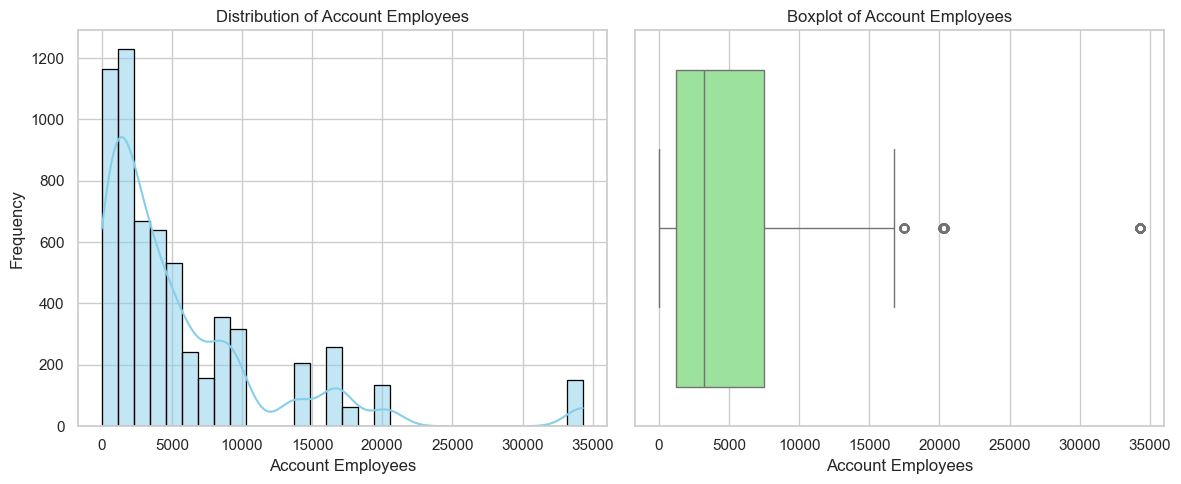

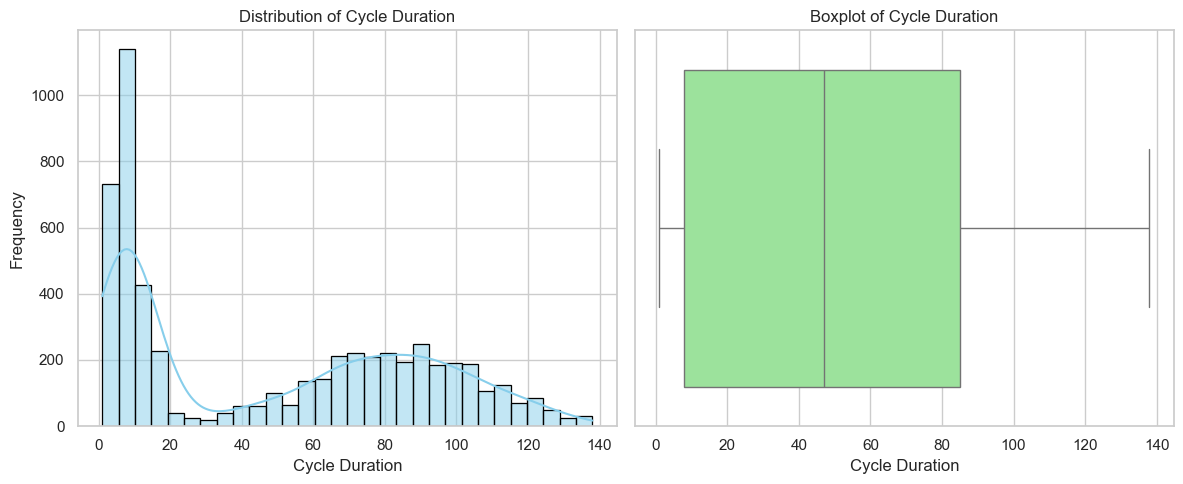

In [32]:
for col in quatitative_sales_features:
    
    if col == 'close_value':
        df_temp = df_sales_data[df_sales_data['close_value'] > 0]
        plotting_boxplot_histogram(df_temp, col)
        
    elif col == 'cycle_duration':
        df_temp = df_sales_data[col].to_frame()
        df_temp.dropna(inplace=True)
        plotting_boxplot_histogram(df_temp, col)
        
    else:
        plotting_boxplot_histogram(df_sales_data, col)

# Total Closed Compared to Other Variables

For this section, we want to understand how New ARR closed over the year compared for the following categories:
- Q1-Q4
- Different Teams
- Industries
- Size Category
- Product and Product Series
- Months 

In [33]:
# Creating a new df to just focused on closed pipeline
df_sales_data_closed = df_sales_data[df_sales_data['deal_stage'] == 'Won']
df_sales_data_closed.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,cycle_duration,quarter_close,account_sector,account_revenue,account_employees,office_location,size_category,manager,regional_office,series,sales_price
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,132.0,Q1 2017,retail,718.62,2448,United States,Enterprise,Dustin Brinkmann,Central,GTX,1096
1,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,133.0,Q1 2017,retail,718.62,2448,United States,Enterprise,Melvin Marxen,Central,MG,55
2,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,135.0,Q1 2017,software,2714.90,2641,United States,Enterprise,Dustin Brinkmann,Central,GTX,550
3,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,128.0,Q1 2017,services,792.46,1299,United States,Mid-Market,Summer Sewald,West,GTX,550
4,ZNBS69V1,Anna Snelling,MG Special,Ron-tech,Won,2016-10-29,2017-03-01,49.0,123.0,Q1 2017,medical,3922.42,6837,United States,Enterprise,Dustin Brinkmann,Central,MG,55


In [34]:
#Plotting function for bar charts
def plot_revenue_barchart(df):
    sns.set_style("whitegrid")

    plt.clf()
    col = list(df.columns)[0]

    ax = plt.subplots(figsize=(8, 5))

    plt.bar(df[col], df['close_value'], color='Green')
    plt.xlabel(col.title())
    plt.xticks(rotation=45)
    plt.ylabel('Revenue Closed (Millions of $)')
    plt.title('Total Revenue Closed by {}'.format(col.title()))

    plt.tight_layout()
    plt.show()

# Net New ARR closed across Q1, Q2, Q3, Q4 for 2017

In [35]:
df_sales_data['quarter_close'].unique()

array(['Q1 2017', None, 'Q2 2017', 'Q3 2017', 'Q4 2017'], dtype=object)

In [36]:
# Grouping total revenue closed for each quarter 
quarter_revenue = df_sales_data_closed.groupby('quarter_close')['close_value'].sum()
quarter_revenue = quarter_revenue.reset_index()
quarter_revenue

,quarter_close,close_value
0,Q1 2017,757706.0
1,Q2 2017,2007589.0
2,Q3 2017,1885656.0
3,Q4 2017,1844005.0


<Figure size 640x480 with 0 Axes>

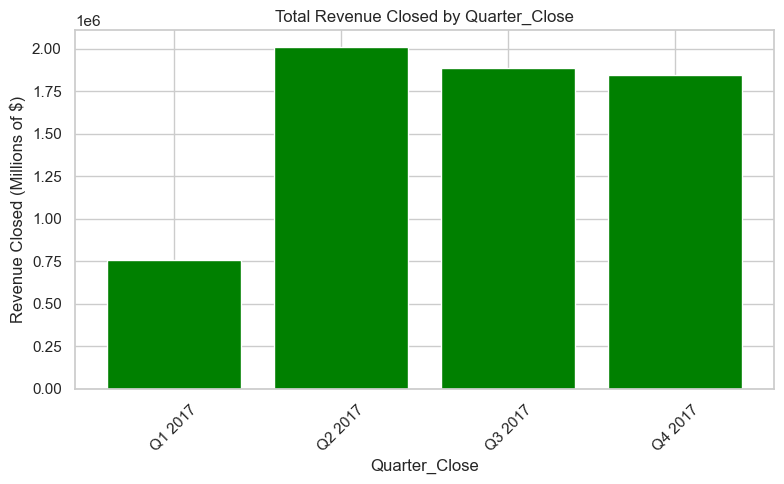

In [37]:
plot_revenue_barchart(quarter_revenue)

# Net New ARR closed across industries

In [38]:
# Grouping total revenue closed for each manager 
sector_revenue = df_sales_data_closed.groupby('account_sector')['close_value'].sum()
sector_revenue = sector_revenue.reset_index()
sector_revenue

,account_sector,close_value
0,employment,292625.0
1,entertainment,507337.0
2,finance,606345.0
3,marketing,591634.0
4,medical,927174.0
5,retail,1210093.0
6,services,313999.0
7,software,663677.0
8,technolgy,933461.0
9,telecommunications,448611.0


<Figure size 640x480 with 0 Axes>

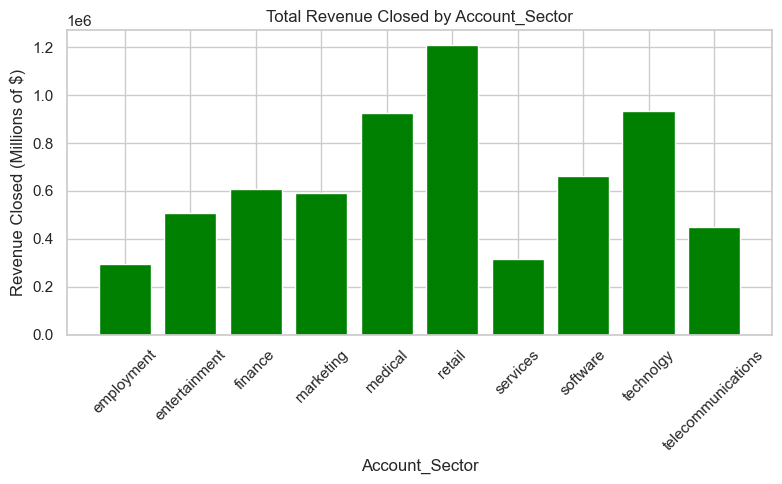

In [39]:
plot_revenue_barchart(sector_revenue)

# Net New ARR closed across teams

In [40]:
# Grouping total revenue closed for each industry of customer account 
team_revenue = df_sales_data_closed.groupby('manager')['close_value'].sum()
team_revenue = team_revenue.reset_index()
team_revenue

,manager,close_value
0,Cara Losch,694695.0
1,Celia Rouche,1259786.0
2,Dustin Brinkmann,1094363.0
3,Melvin Marxen,1147821.0
4,Rocco Neubert,1110252.0
5,Summer Sewald,1188039.0


<Figure size 640x480 with 0 Axes>

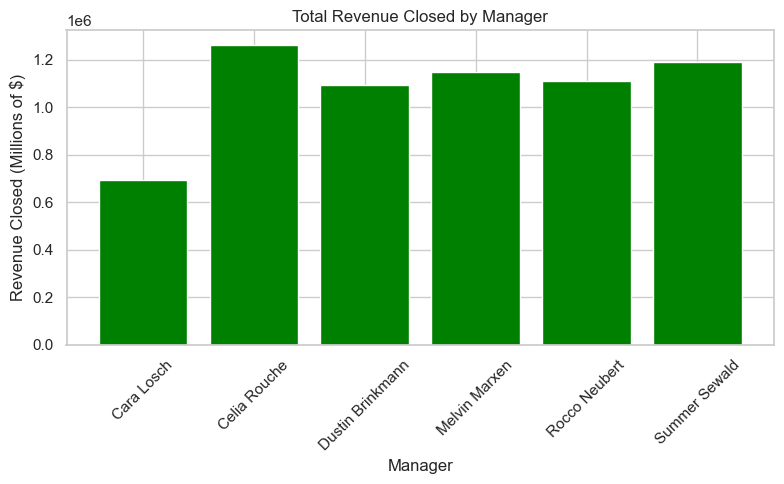

In [41]:
plot_revenue_barchart(team_revenue)

# Net New ARR closed across size categories of customer accounts

In [42]:
# Grouping total revenue closed for each size category of customer account 
size_revenue = df_sales_data_closed.groupby('size_category', observed=False)['close_value'].sum()
size_revenue = size_revenue.reset_index()
size_revenue

,size_category,close_value
0,SMB,754489.0
1,Mid-Market,884978.0
2,Enterprise,4855489.0


<Figure size 640x480 with 0 Axes>

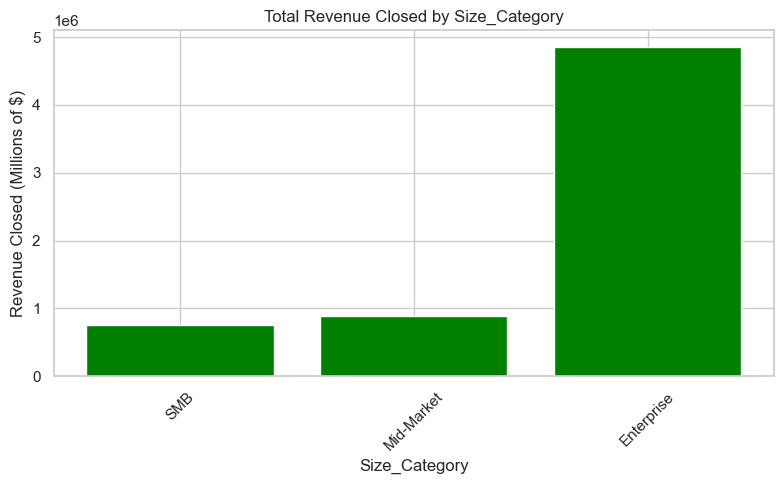

In [43]:
plot_revenue_barchart(size_revenue)

In [44]:
df_month_revenue = df_sales_data_closed[['close_date','close_value']]
df_month_revenue = df_month_revenue.set_index('close_date')
revenue_by_month = df_month_revenue.resample('ME').sum()
revenue_by_month
#revenue_by_month = df_month_revenue.resample('M').sum()
#revenue_by_month

,close_value
close_date,
2017-03-31,757706.0
2017-04-30,449481.0
2017-05-31,673137.0
2017-06-30,884971.0
2017-07-31,443197.0
2017-08-31,696390.0
2017-09-30,746069.0
2017-10-31,466965.0
2017-11-30,622472.0


<Figure size 640x480 with 0 Axes>

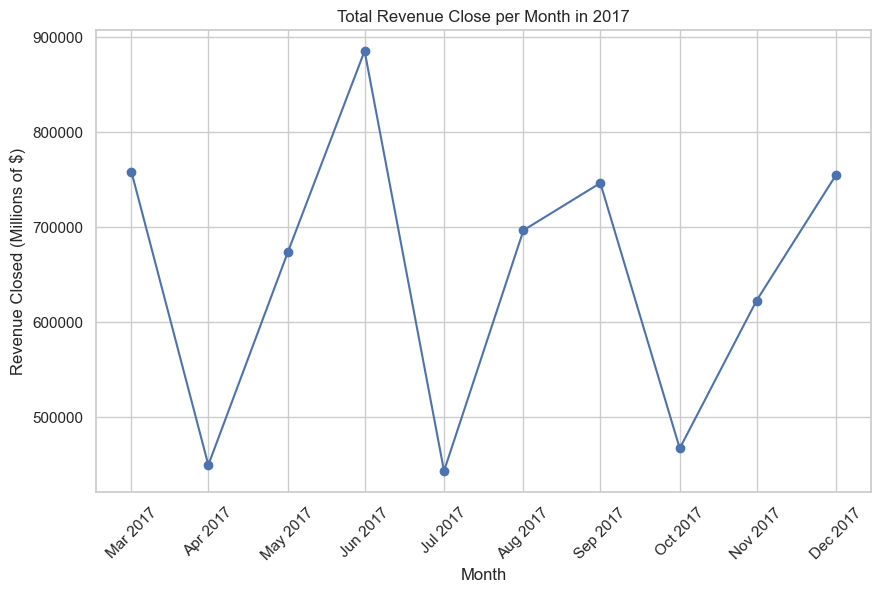

In [45]:
plt.clf()

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(revenue_by_month.index, revenue_by_month.values, marker='o', linestyle='-')

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Revenue Closed (Millions of $)')
plt.title('Total Revenue Close per Month in 2017')

ax.set_xticks(revenue_by_month.index)
ax.set_xticklabels(revenue_by_month.index.strftime('%b %Y'), rotation=45)

plt.show()

In [46]:
product_revenue = df_sales_data_closed.groupby(['series','product'])['close_value'].sum()
product_revenue = product_revenue.reset_index()
product_revenue

,series,product,close_value
0,GTK,GTK 500,400612.0
1,GTX,GTX Basic,499263.0
2,GTX,GTX Plus Basic,705275.0
3,GTX,GTX Plus Pro,2629651.0
4,MG,MG Advanced,2216387.0
5,MG,MG Special,43768.0


In [47]:
pivot_product_rev = product_revenue.pivot(index='series', columns='product', values='close_value')
pivot_product_rev

product,GTK 500,GTX Basic,GTX Plus Basic,GTX Plus Pro,MG Advanced,MG Special
series,,,,,,
GTK,400612.0,NaN,NaN,NaN,NaN,NaN
GTX,NaN,499263.0,705275.0,2629651.0,NaN,NaN
MG,NaN,NaN,NaN,NaN,2216387.0,43768.0


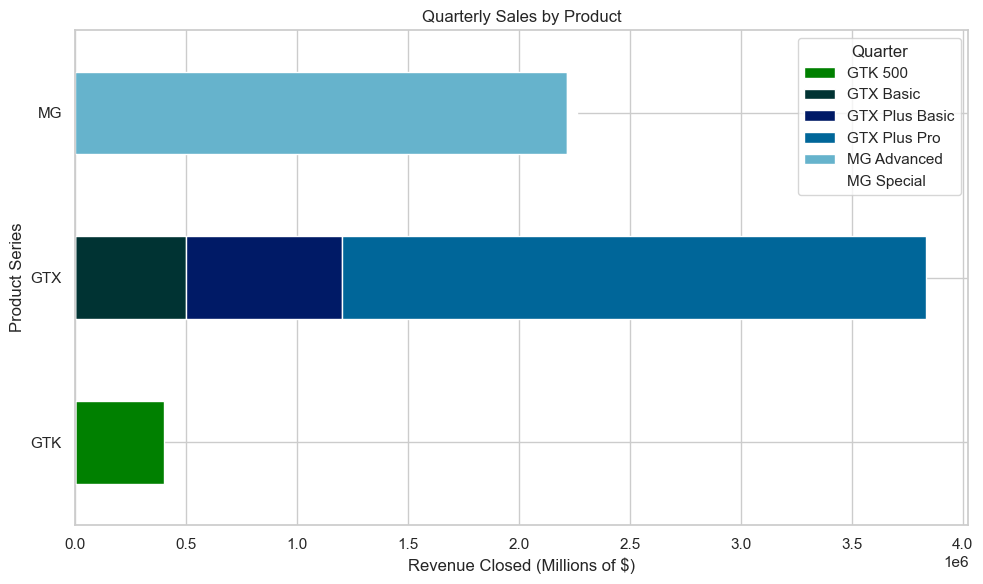

In [48]:
pivot_product_rev.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='ocean', )
plt.title('Quarterly Sales by Product')
plt.ylabel('Product Series')
plt.xlabel('Revenue Closed (Millions of $)')
plt.legend(title='Quarter')

plt.tight_layout()
plt.show()

Key Takeaways:

Reflecting net new revenue closed for the year 2017, Q2 saw the highest new net ARR at $1,844,005.00 closed, with most of that revenue coming from June. The sales agents under Celia Rouche had the highest collective revenue closed for the year. Interestingly, we saw that Retail companies are the highest proportion of new customers across the year, with most deals coming from the enterprise side. The GTX Product series was the most popular among all the product series, with the Plus Pro bringing in the most revenue for the year. 

For following years, the company should continue to market and focus on other retail accounts while prepping the team to have another successful Q2. The company should also consider more prospecting in Q4 to make up with the low potential of Q1 as it seems to be the weakest quarter in terms of new new revenue. Product and Engineering should also focus their efforts on the GTX product series while understanding why GTK underperformed. 

# Understanding Sales Stages for the year 
For this section, the goal is to understand sales stages and what the sales cycle entails across all sales team. Key sections:
- Binomial Test for closing rates
- Average duration to closed won
- Categorical analysis of deal stages

# Binomial Test for Closed Rates

The sales department has always assumed that out of 100 oppurtunities, 30 oppurtunities will result in closed won (30% close rate). Looking at this year's sales pipeline, we will run a one-sided Binomial Test with the following hypotheses:

- Null Hypothesis: The closed won rate is 30% 
- Alternative Hypothesis: The closed won rate is more than 30%

We will assume a significant threshold of 0.05. We are assuming that each oppurtunity is independent and we are working with a fixed number of "trials" for the period 2017.

In [49]:
#Let's again get the total number of distinct and independent oppurtunities across the year and determine how many closed
total_closed_won = len(df_sales_data[df_sales_data['deal_stage'] == 'Won'])
total_closed_won

3509

In [50]:
total_opps = len(df_sales_data)
total_opps

6117

In [51]:
# total opportunities
n = 6117

# assumed close rate under H0
p = 0.30        

# observed closed-won deals
k_obs = total_closed_won       

From the year, we see that out of 100 oppurtunities, 57 closed. Let's run the one-sided Binomial test to determine if this is significant.

In [52]:
closed_won_test = stats.binomtest(k_obs, n, p=p, alternative='greater')

if closed_won_test.pvalue < 0.05:
    print("Reject the null hypothesis: Evidence suggests the close rate is > 30%")
else:
    print("Fail to reject the null hypothesis: No significant evidence the close rate is > 30%")

Reject the null hypothesis: Evidence suggests the close rate is > 30%


In [53]:
#Builing a 95% confidence interval for the closed won rate
ci_low, ci_upp = proportion_confint(count=k_obs, nobs=n, alpha=0.05, method='beta')

print('95% Confidence Interval: ({}, {})'.format(round(ci_low,2), round(ci_upp, 2)))

95% Confidence Interval: (0.56, 0.59)


To conclude, we have enough evidence to reject the null, where the closed won rates are 30% and are 95% confident that the closed won rates fall somewhere between 56% and 59%.

# Closing Rates per Agent

In [54]:
def close_rate(agent):
    df = df_sales_data[df_sales_data['sales_agent'] == agent]
    total_opps = len(df)
    total_closed = len(df[df['deal_stage'] == 'Won'])
    return round(total_closed / total_opps, 2)

In [55]:
df_sales_data['close_rate'] = df_sales_data['sales_agent'].apply(close_rate)
closing_rate_df = df_sales_data[['manager', 'sales_agent', 'close_rate']]
closing_rate_df = closing_rate_df.drop_duplicates()
closing_rate_df.head()

,manager,sales_agent,close_rate
0,Dustin Brinkmann,Moses Frase,0.60
1,Melvin Marxen,Darcel Schlecht,0.60
3,Summer Sewald,Zane Levy,0.54
4,Dustin Brinkmann,Anna Snelling,0.55
5,Celia Rouche,Vicki Laflamme,0.58


<Figure size 640x480 with 0 Axes>

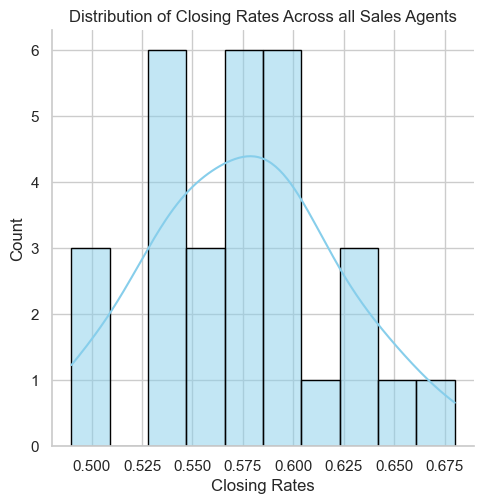

In [56]:
plt.clf()
sns.displot(closing_rate_df['close_rate'], bins = 10, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Closing Rates Across all Sales Agents')
plt.xlabel('Closing Rates')
plt.show()

In [57]:
closing_rate_df.groupby('manager')['close_rate'].mean().reset_index().max()

manager       Summer Sewald
close_rate            0.594
dtype: object

Seems that Summer Sewald lead the team with the highest closing rates, at nearly 60%.

# Understanding what sales stage was the most common all year

In [58]:
df_sales_data['deal_stage'].dtype

CategoricalDtype(categories=['Prospecting', 'Engaging', 'Lost', 'Won'], ordered=True, categories_dtype=object)

In [59]:
median_deal_stage = np.median(df_sales_data['deal_stage'].cat.codes)
median_deal_stage

3.0

Seems that the median deal stage was during the 'Engaging' phase, where the team met with the account and determine next steps or the account then chose to not move forward.

# Understanding if Sector and Products are not independent

Reviewing closed won oppurtunities for the year 2017, we want to understand if an account's sector is independent to the product they end up choosing. Since both features are categorical variables, we will use a Chi-Squared Test of Independence.

- Null hypothesis: Account Sector and the Product they purchased are indpendent
- Althernative hypothesis: Account Sector and the Product they purchased are dependent

We will choose a significance level of 0.05 and we are assuming that each oppurtunity is independent. 

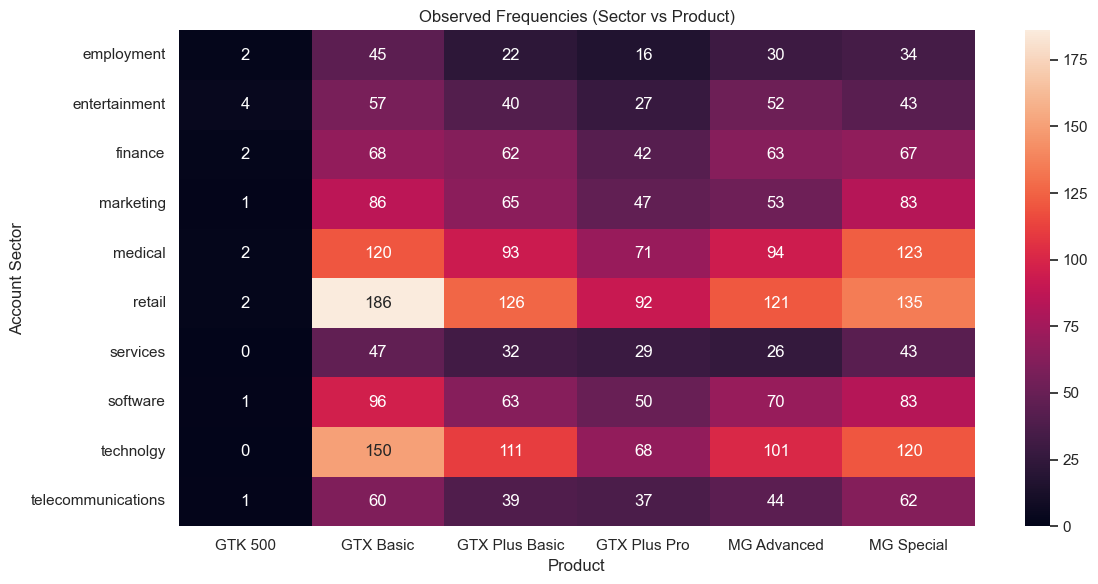

In [79]:
#First step is to build out the contigency table, where there are 10 rows of sectors and six columns of products.
contingecy_table = pd.crosstab(df_sales_data_closed['account_sector'], df_sales_data_closed['product'])

plt.figure(figsize=(12, 6))
sns.heatmap(contingecy_table, annot=True, fmt="d")
plt.title("Observed Frequencies (Sector vs Product)")
plt.ylabel("Account Sector")
plt.xlabel("Product")
plt.tight_layout()
plt.show()


In [87]:
#Let's tun the 
chi2, pval, dof, contingency_expected = stats.chi2_contingency(contingecy_table)

if pval < 0.05:
    print("Reject the null hypothesis: Evidence suggests that account sector and product purchased are dependent, p-value was {}".format(pval))
else:
    print("Fail to reject the null hypothesis: Evidence suggests that account sector and product purchased are independent, p-value was {}".format(pval))

Fail to reject the null hypothesis: Evidence suggests that account sector and product purchased are independent, p-value was 0.6346663049972449


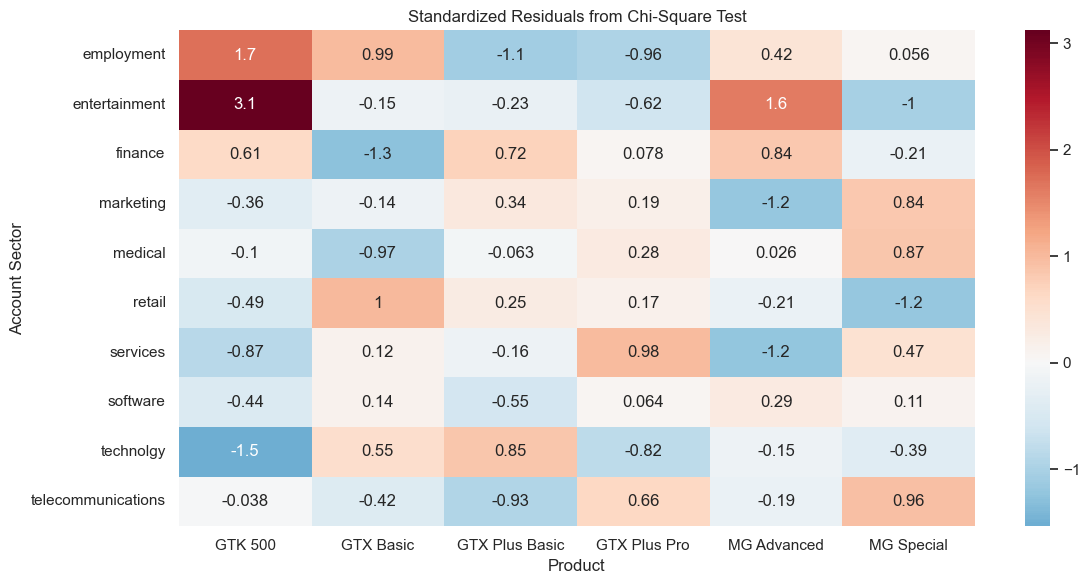

In [82]:
#Visualizing the residuals from the test
residuals = (contingecy_table - contingency_expected) / np.sqrt(contingency_expected)

plt.figure(figsize=(12, 6))
sns.heatmap(residuals, annot=True, cmap="RdBu_r", center=0)
plt.title("Standardized Residuals from Chi-Square Test")
plt.ylabel("Account Sector")
plt.xlabel("Product")
plt.tight_layout()
plt.show()

To conclude: there is no statistically significant association between account sector and product choice.